In [7]:
import pandas as pd
import geopandas as gpd
from modules import preprocess
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
state_selector = ['08', '20', '31', '40', '46', '48'] 
static_features = ["awc", "bulk_density", "drainage_class_1", "drainage_class_2", "drainage_class_3", "drainage_class_4", "drainage_class_5", "drainage_class_6"]
temporal_prefixes = ["tavg", "prec", "tmin", "tmax", "ndvi", "fpar", "rad", "et0", "cwb", "ssm", "rsm"]
# Enable autoreload for Jupyter notebooks
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
cc = pd.read_csv("../data/CY-Bench/US/wheat/crop_calendar_wheat_US.csv")
cc = cc.assign(state=cc["adm_id"].apply(lambda x: x.split("-")[1]), year=2010, eos=cc["eos"].apply(lambda x: int(x)), sos=cc["sos"].apply(lambda x: int(x)))
cc = cc.loc[cc["state"].isin(state_selector)].groupby("state").agg({"eos":[min, max]})["eos"].reset_index()
cc = cc.assign(year=2010)
cc['eos_max_date'] = pd.to_datetime(cc['year'].astype(str) + cc['max'].astype(str), format='%Y%j')
cc['eos_max_date'] = cc['eos_max_date'].dt.strftime('%d-%b')
cc['eos_min_date'] = pd.to_datetime(cc['year'].astype(str) + cc['min'].astype(str), format='%Y%j')
cc['eos_min_date'] = cc['eos_min_date'].dt.strftime('%d-%b')
usda_min_dates = ["2010-07-02", "2010-06-20", "2010-07-03", "2010-06-06", "2010-07-14", "2010-06-01"]
usda_max_dates = ["2010-07-21", "2010-07-05", "2010-07-21", "2010-06-27", "2010-08-05", "2010-07-02"]
cc["usda_eos_min_date"] = usda_min_dates
cc["usda_eos_max_date"] = usda_max_dates
cc["usda_eos_max_date"] = pd.to_datetime(cc["usda_eos_max_date"]).dt.day_of_year
cc["usda_eos_min_date"] = pd.to_datetime(cc["usda_eos_min_date"]).dt.day_of_year

cc['eos_max_date'] = pd.to_datetime(cc['year'].astype(str) + cc['max'].astype(str), format='%Y%j')
cc['eos_max_date'] = cc['eos_max_date'].dt.strftime('%d-%b')
cc = cc.sort_values("usda_eos_min_date", ascending=False).reset_index(drop=True)

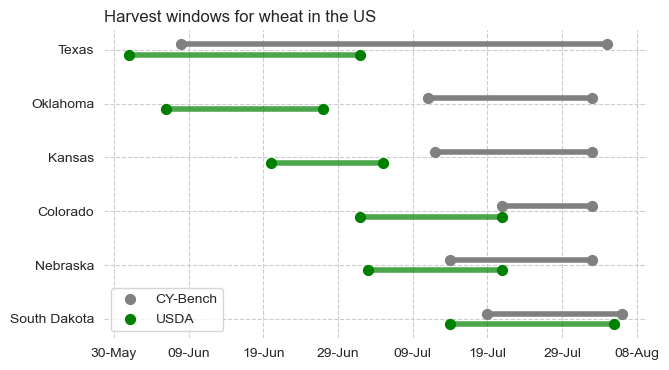

In [9]:
plt.figure(figsize=(7, 4))
sns.set_style("whitegrid", {"grid.linestyle": "--"})
my_range = range(1, len(cc.index) + 1)

ax = plt.axes(frameon=False)

# Plot the CY-Bench horizontal lines slightly above the USDA lines
plt.hlines(y=[y + 0.1 for y in my_range], xmin=cc['min'], xmax=cc['max'], color='grey', lw=4)
plt.hlines(y=[y - 0.1 for y in my_range], xmin=cc['usda_eos_min_date'], xmax=cc['usda_eos_max_date'], color='green', lw=4, alpha=0.7)

plt.scatter(cc['min'], [y + 0.1 for y in my_range], color='grey', s=50, label='CY-Bench')
plt.scatter(cc['max'], [y + 0.1 for y in my_range], color='grey', s=50)

plt.scatter(cc['usda_eos_min_date'], [y - 0.1 for y in my_range], color='green', s=50, label='USDA')
plt.scatter(cc['usda_eos_max_date'], [y - 0.1 for y in my_range], color='green', s=50)

plt.yticks(my_range, ['South Dakota', 'Nebraska', 'Colorado', 'Kansas', 'Oklahoma', 'Texas'])
plt.xticks(range(150, 230, 10), ["30-May", "09-Jun", "19-Jun", "29-Jun", "09-Jul", "19-Jul", "29-Jul", "08-Aug"]) 

plt.title("Harvest windows for wheat in the US", loc="left")
plt.legend()

### 1. Define study crop and country

In [10]:
# USER INPUTS
country = "US" # one of ["US", "BR"]
crop = "wheat" # one of ["maize", "wheat"]

shapefile_path, crop_season_in_days_of_year, crop_season_in_months, offset, test_years = preprocess.get_study_metadata(country, crop)
crop_season_in_days_of_year = tuple([1, 365])
crop_season_in_months = tuple([8, 7])
print(shapefile_path, crop, country, crop_season_in_days_of_year, crop_season_in_months, offset, test_years)

../data/shapefiles/US/tl_2023_us_county.shp wheat US (1, 365) (8, 7) 19 [2021, 2022, 2023]


### 2. Read data

From CY-Bench, we have five predictor datasets. 
 
| **ID** | **Name**        | **Time** | **Variables**                         | **Steps**                                    | 
|--------|-----------------|----------|---------------------------------------|----------------------------------------------|
| 1      | FPAR            | bins     | fpar                                  | filter adm_ids, filter crop season           |            
| 2      | METEO           | daily    | tmin, tmax, prec, rad, tavg, et0, cwb | filter adm_ids, filter crop season,<br>resample to 8-day bins  |        
| 3      | NDVI            | bins     | ndvi                                  | filter adm_ids, filter crop season, pivotieren           |           
| 4      | SOIL MOISTURE   | daily    | ssm, rsm                              | filter adm_ids, filter crop season, <br>resample to 8-day bins, pivotieren  |          
| 5      | SOIL            | static   | awc, bulk_density, drainage_class     | filter adm_ids, pivotieren                                |         


In [44]:
# CY-Bench data
fpar = pd.read_csv("../data/CY-Bench/{}/{}/fpar_{}_{}.csv".format(country, crop, crop, country)) 
meteo = pd.read_csv("../data/CY-Bench/{}/{}/meteo_{}_{}.csv".format(country, crop, crop, country), usecols=['crop_name','adm_id','date','rad','et0','cwb', 'tavg', 'tmin', 'tmax', 'prec'])
ndvi = pd.read_csv("../data/CY-Bench/{}/{}/ndvi_{}_{}.csv".format(country, crop, crop, country)) 
soil_moisture = pd.read_csv("../data/CY-Bench/{}/{}/soil_moisture_{}_{}.csv".format(country, crop,  crop, country))
soil = pd.read_csv("../data/CY-Bench/{}/{}/soil_{}_{}.csv".format(country, crop, crop, country)) 
yield_data = pd.read_csv("../data/CY-Bench/{}/{}/yield_{}_{}.csv".format(country, crop, crop, country))

### 3. Preprocess

In [45]:
cy_bench_data = [fpar, soil_moisture, ndvi, soil, meteo]
relevant_adm_ids = yield_data["adm_id"].unique()
cy_bench_data = preprocess.filter_predictors_by_adm_ids(cy_bench_data, relevant_adm_ids)
fpar, soil_moisture, ndvi, soil, meteo = cy_bench_data

In [46]:
temporal_cy_bench_data = [fpar, soil_moisture, ndvi, meteo]
temporal_cy_bench_data = preprocess.preprocess_temporal_data(temporal_cy_bench_data, crop_season_in_months, crop_season_in_days_of_year, crop, country)
 
fpar, soil_moisture, ndvi, meteo = temporal_cy_bench_data

In [47]:
# merge
predictors = (soil_moisture
              .merge(ndvi 
                     .merge(meteo
                            .merge(fpar, on=["adm_id", "harvest_year"], how="inner"), 
                            on=["adm_id", "harvest_year"], how="inner"), 
                     on=["adm_id", "harvest_year"], how="inner")
              .merge(soil.drop("crop_name", axis=1), on="adm_id", how="left"))

# one-hot encode drainage_class and drop
predictors = (predictors
              .join(pd.get_dummies(predictors["drainage_class"].astype('Int64'), dtype=int, prefix="drainage_class"))
              .drop("drainage_class", axis=1))

In [48]:
predictors = preprocess.interpolate_fpar_timesteps(predictors, "tavg")
predictors = preprocess.order_temporal_features(predictors, temporal_prefixes)
predictors = predictors.assign(state=predictors["adm_id"].apply(lambda x: x.split("-")[1]))
predictors = predictors.loc[predictors["state"].isin(['08', '20', '31', '40', '46', '48'])].reset_index(drop=True)
predictors = predictors.drop("state", axis=1)

In [49]:
predictors_16day_bins = preprocess.temporal_aggregation_from8day_to_window(predictors, temporal_prefixes, 2)

Now we have two predictor datasets:

- predictors: where the temporal features are in 8day bins
- predictors_16day_bins: where the temporal features are in 16day bins

### Add additional features

### lat, lon of adm_id


In [50]:
us_shape = gpd.read_file(shapefile_path)

us_shape = us_shape.assign(adm_id="US-"+us_shape["STATEFP"]+"-"+us_shape["COUNTYFP"],
                centroid=us_shape["geometry"].to_crs(epsg=32723).centroid)[["adm_id", "geometry", "centroid"]]

county_centroids = us_shape.assign(lon=us_shape["centroid"].to_crs(epsg=4326).x, lat=us_shape["centroid"].to_crs(epsg=4326).y).drop(["centroid", "geometry"], axis=1)

predictors = predictors.merge(county_centroids, on="adm_id", how="left")
predictors_16day_bins = predictors_16day_bins.merge(county_centroids, on="adm_id", how="left")

### yield of past years

In [51]:
yield_data = yield_data.loc[(yield_data["adm_id"].isin(predictors["adm_id"].unique())) & (yield_data["harvest_year"].between(1999, 2023))].reset_index(drop=True)

yield_data_pivot = yield_data.pivot(index="adm_id", columns="harvest_year", values="yield")
yield_data_pivot = (pd.DataFrame(index=pd.MultiIndex.from_frame(yield_data[["adm_id", "harvest_year"]]))
                  .reset_index(level=1).rename(columns={"level_1": "harvest_year"})
                  .merge(yield_data_pivot, left_index=True, right_index=True, how="left")
                  .reset_index(drop=False))
yield_data_pivot = yield_data_pivot.loc[yield_data_pivot["harvest_year"].between(2004, 2023)].reset_index(drop=True)
yield_data_pivot = yield_data_pivot.set_index(["adm_id", "harvest_year"])

In [52]:
li = []
for row in yield_data_pivot.index:
    temp = yield_data_pivot.loc[row, list(range(row[1]-5, row[1]))]
    temp = pd.DataFrame(dict(zip([f"yield_{i}" for i in range(-5, 0)], temp.values), index=[0])).drop(columns=["index"])
    temp = temp.interpolate(axis=1, limit_direction="both")
    temp = temp.set_index(pd.MultiIndex.from_tuples([row])).reset_index().rename(columns={"level_0": "adm_id", "level_1": "harvest_year"})
    li.append(temp)

yield_past_years = pd.concat(li, axis=0)
yield_past_years = yield_past_years.dropna().reset_index(drop=True)

In [53]:
yield_past_years.head(2)

,adm_id,harvest_year,yield_-5,yield_-4,yield_-3,yield_-2,yield_-1
0,US-08-001,2010,2.2882,2.2882,2.2882,1.91805,2.45645
1,US-08-001,2009,2.2882,2.2882,2.2882,2.28820,1.91805


#### Merge with predictors

In [54]:
predictores_with_yield = predictors.merge(yield_past_years, on=["adm_id", "harvest_year"], how="inner")
predictores_16day_bins_with_yield = predictors_16day_bins.merge(yield_past_years, on=["adm_id", "harvest_year"], how="inner")

#### Add EOS info on adm-level

In [55]:
calendar = pd.read_csv("../data/CY-Bench/US/wheat/crop_calendar_wheat_US.csv")
predictores_16day_bins_with_yield = predictores_16day_bins_with_yield.merge(calendar[["adm_id", "eos"]], on="adm_id", how="left")

# EXPORT

In [42]:
predictores_16day_bins_with_yield.to_csv("../data/preprocessed/{}/cy_bench_16daybins_{}_{}_v8.csv".format(country, crop, country), index=False)